In [106]:
import numpy as np
import gym
import math
import random
from collections import namedtuple
from itertools import count
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

In [107]:
env = gym.make('CartPole-v1')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [108]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory:
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = list()
        self.position = 0
    
    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        
        self.position += 1
        if self.position == self.capacity:
            self.position = 0
            
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
        

In [109]:
N_ATOMS = 51
V_MIN = -10
V_MAX = 10
N_STEPS = 1
LR = 1e-4

In [110]:
class CategoricalDQN(nn.Module):

    def __init__(self, outputs, n_atoms):
        super(CategoricalDQN, self).__init__()      
        
        self.outputs = outputs
        self.n_atoms = n_atoms
        self.first = nn.Linear(4, 512)
        self.output = nn.Linear(512, outputs * self.n_atoms)

    def forward(self, x):
        x = F.relu(self.first(x))
        x = self.output(x)
        return F.softmax(x.view(-1, self.outputs, self.n_atoms), dim=2)


In [111]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
MEMORY_SIZE = 100000
TARGET_UPDATE = 500

In [112]:
n_actions = env.action_space.n
steps_done = 0
episode_durations = list()

net = CategoricalDQN(n_actions, N_ATOMS).to(device)
target_net = CategoricalDQN(n_actions, N_ATOMS).to(device)
optimizer = optim.Adam(net.parameters(), lr=LR)
memory = ReplayMemory(MEMORY_SIZE)

In [113]:
def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated

In [114]:
supports = torch.linspace(V_MIN, V_MAX, N_ATOMS).view(1, 1, N_ATOMS).to(device)
delta = (V_MAX - V_MIN) / (N_ATOMS - 1)

In [115]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            a = net(state) * supports
            return a.sum(dim=2).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], dtype=torch.long, device=device)

In [116]:
def get_max_next_state_action(next_states):
    next_dist = target_net(next_states) * supports
    return next_dist.sum(dim=2).max(1)[1].view(next_states.size(0), 1, 1).expand(-1, -1, N_ATOMS)

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)

    batch = Transition(*zip(*transitions))
    
    batch_state = torch.cat(batch.state)
    batch_action = torch.cat(batch.action).unsqueeze(dim=-1).expand(-1, -1, N_ATOMS)
    batch_reward = torch.cat(batch.reward)
    batch_next_state = torch.cat(batch.next_state)
    
    
    with torch.no_grad():
        max_next_action = get_max_next_state_action(batch_next_state)
        max_next_dist = target_net(batch_next_state).gather(1, max_next_action)
        max_next_dist = max_next_dist.squeeze()

        Tz = batch_reward.view(-1, 1) + (GAMMA**N_STEPS) * supports.view(1, -1)
        Tz = Tz.clamp(V_MIN, V_MAX)
        b = (Tz - V_MIN) / delta
        l = b.floor().to(torch.int64)
        u = b.ceil().to(torch.int64)
        l[(u > 0) * (l == u)] -= 1
        u[(l < (N_ATOMS - 1)) * (l == u)] += 1

        offset = torch.linspace(0, (BATCH_SIZE - 1) * N_ATOMS, BATCH_SIZE).unsqueeze(dim=1).expand(BATCH_SIZE, N_ATOMS).to(batch_action)
        m = batch_state.new_zeros(BATCH_SIZE, N_ATOMS)
        m.view(-1).index_add_(0, (l + offset).view(-1), (max_next_dist * (u.float() - b)).view(-1))  # m_l = m_l + p(s_t+n, a*)(u - b)
        m.view(-1).index_add_(0, (u + offset).view(-1), (max_next_dist * (b - l.float())).view(-1))  # m_u = m_u + p(s_t+n, a*)(b - l)
    
    state_action_dist = net(batch_state).gather(1, batch_action).squeeze()

    loss = -(m * state_action_dist.log()).sum(-1)
    loss = loss.mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Complete epoch 0 32.64
Complete epoch 1 99.54
Complete epoch 2 166.06
Complete epoch 3 168.3
Complete epoch 4 162.16
Complete epoch 5 162.16


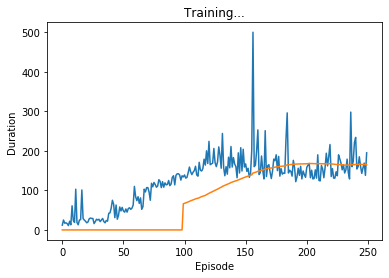

In [117]:
num_episodes = [50] * 5 + [0] * 1
for epoch in range(len(num_episodes)):
    for i_episode in range(num_episodes[epoch]):
        state = torch.tensor([env.reset()], dtype=torch.float, device=device)
        for t in count():
            action = select_action(state)
            if epoch == len(num_episodes) - 1:
                env.render()
            next_state, reward, done, _ = env.step(action.item())
            
            if next_state is None:
                next_state = state
            else:
                next_state = torch.tensor([next_state], dtype=torch.float, device=device)
                
            if done and t + 1 != 500:
                reward = -100
                
            reward = torch.tensor([reward], dtype=torch.float, device=device)
         
            memory.push(state, action, next_state, reward)
            state = next_state
            optimize_model()
            
            if steps_done % TARGET_UPDATE == 0:
                target_net.load_state_dict(net.state_dict())

            if done:
                episode_durations.append(t + 1)
                break

    print('Complete epoch {}'.format(epoch), np.mean(episode_durations[-50:]))
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
env.close()
plot_durations()
plt.show()